In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [1]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [2]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [103]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y[:,np.newaxis] - tx @ w[:,np.newaxis]
    loss = (e.T @ e) / tx.shape[0]
    return loss.item()

# 2 Grid Search

Fill in the function `grid_search()` below:

In [41]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i in range(len(w0)):
        for j in range(len(w1)):
            losses[i,j] = compute_loss(y,tx, [[w0[i]],[w1[j]]])
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=84.84896629356496, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.006 seconds


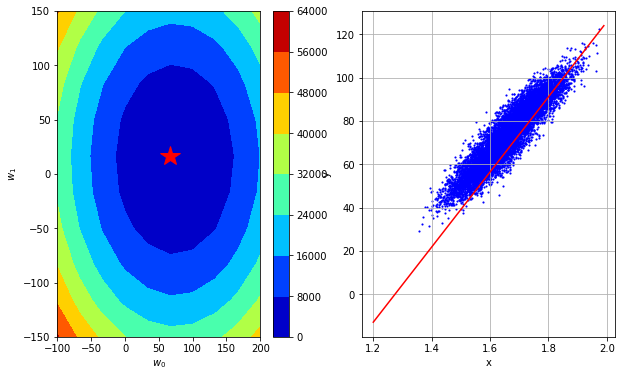

In [47]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [92]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y[:,np.newaxis] - tx @ w[:,np.newaxis]
    return - (tx.T[:,np.newaxis] @ e) / tx.shape[0]

Please fill in the functions `gradient_descent` below:

In [112]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        loss = compute_loss(y,tx,w)
        gradient = compute_gradient(y,tx,w).flatten()
        w = w - gamma * gradient
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [121]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=5584.473425518336, w0=51.3057454014736, w1=9.435798704492274
Gradient Descent(1/49): loss=530.6049242179214, w0=66.69746902191571, w1=12.266538315839998
Gradient Descent(2/49): loss=75.75675910088253, w0=71.31498610804834, w1=13.11576019924433
Gradient Descent(3/49): loss=34.82042424034894, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=31.136154102900914, w0=73.11581777164007, w1=13.446956733772023
Gradient Descent(5/49): loss=30.80456979053059, w0=73.24049073296565, w1=13.469885724623941
Gradient Descent(6/49): loss=30.77472720241726, w0=73.27789262136332, w1=13.476764421879516
Gradient Descent(7/49): loss=30.77204136948706, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=30.77179964452334, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=30.771777889276603, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=30.7717759313044, w0=73.29379216412119, w1=13.4796885

In [118]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

# 4 Stochastic gradient descent

In [129]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    e = y[:,np.newaxis] - tx @ w[:,np.newaxis]
    return - (tx.T[:,np.newaxis] @ e) / tx.shape[0]


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        loss = compute_loss(y,tx,w)
        for minibatch_y, minibatch_tx in batch_iter(y,tx, batch_size):
            gradient = compute_gradient(minibatch_y,minibatch_tx,w).flatten()
        w = w - gamma * gradient
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [130]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=5584.473425518336, w0=6.120956330528485, w1=-8.59251347815926
Gradient Descent(1/49): loss=5030.162249613533, w0=14.468637350892454, w1=0.35408515015791053
Gradient Descent(2/49): loss=3663.4679816541648, w0=19.857489580038646, w1=-2.1363907221770013
Gradient Descent(3/49): loss=3130.086763550993, w0=24.394890841840464, w1=-6.398685613214663
Gradient Descent(4/49): loss=2817.037733113026, w0=31.60592102901669, w1=5.683649842495332
Gradient Descent(5/49): loss=1829.4397928159653, w0=34.76169893777304, w1=3.831399195859194
Gradient Descent(6/49): loss=1608.593938377477, w0=40.661569435200164, w1=15.022407661749487
Gradient Descent(7/49): loss=1098.0221183511214, w0=44.29927436101822, w1=12.040641330008507
Gradient Descent(8/49): loss=873.5322932136387, w0=47.41957041995029, w1=13.301508360178268
Gradient Descent(9/49): loss=700.2856022268998, w0=49.244519670744516, w1=16.271624661780756
Gradient Descent(10/49): loss=616.9403021154242, w0=52.604848587534384, w

In [132]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

# 5 Effect of Outliers

### Exercise 5


# 6 Subgradient Descent

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)